In [124]:
# !pip install nltk

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.preprocessing import OneHotEncoder
import string #para remover pontuação
from sklearn.feature_extraction.text import CountVectorizer #para Vetorização
from sklearn.feature_extraction.text import TfidfTransformer #para TF-IDF
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to C:\Users\Yago
[nltk_data]     Angelini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [125]:
#Ler o dataset
df = pd.read_csv(
                "C:/Users/Yago Angelini/Downloads/archive/twitter_training.csv",
                 sep=",",
                 names=["ID","Entity","Sentiment","Tweet"],
                 usecols=[2,3] #Usar apenas as colunas "Sentiment" e "Tweet"
)

In [126]:
#VIsualizar df
df

,Sentiment,Tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  74682 non-null  object
 1   Tweet      73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [128]:
df["Tweet"] = df["Tweet"].astype("str")
df["Sentiment"] = df["Sentiment"].astype("category")

In [129]:
#Transformar texto em letras minúsculas
df["Tweet"] = df["Tweet"].str.lower()

In [130]:
#Descrição das classes
df.groupby("Sentiment").describe()

Tweet                 
            count unique  top freq
Sentiment                         
Irrelevant  12990  12240  nan  115
Negative    22542  21155  nan  184
Neutral     18318  17063  nan  210
Positive    20832  19027  nan  177

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Sentiment  74682 non-null  category
 1   Tweet      74682 non-null  object  
dtypes: category(1), object(1)
memory usage: 656.7+ KB


In [132]:
#Verificar tamanho dos tweets
df["Tamanho"] = df["Tweet"].apply(len)

<Axes: ylabel='Frequency'>

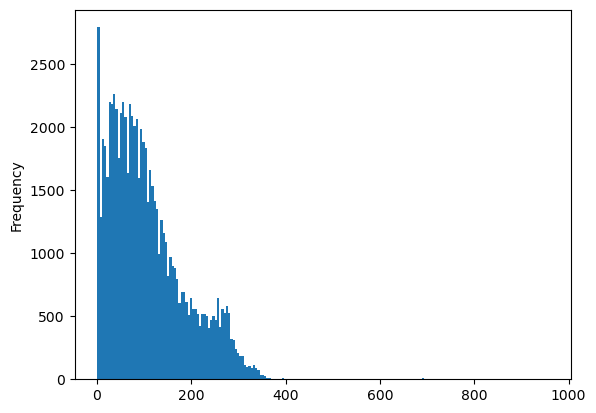

In [133]:
#Gráfico com tamanho das mensagens
df["Tamanho"].plot(bins=200, kind="hist")

In [134]:
#Descrição do tamanho
df.Tamanho.describe()

count    74682.000000
mean       107.811963
std         79.798839
min          1.000000
25%         45.000000
50%         90.000000
75%        152.000000
max        957.000000
Name: Tamanho, dtype: float64

In [135]:
#Achar as mensagens de tamanho 1
df[df["Tamanho"] == 1]

,Sentiment,Tweet,Tamanho
203,Negative,i,1
1107,Positive,.,1
1108,Positive,.,1
1109,Positive,.,1
2292,Irrelevant,,1
...,...,...,...
73758,Negative,,1
73967,Irrelevant,a,1
73968,Positive,,1
74375,Positive,a,1


array([[<Axes: title={'center': 'Irrelevant'}>,
        <Axes: title={'center': 'Negative'}>],
       [<Axes: title={'center': 'Neutral'}>,
        <Axes: title={'center': 'Positive'}>]], dtype=object)

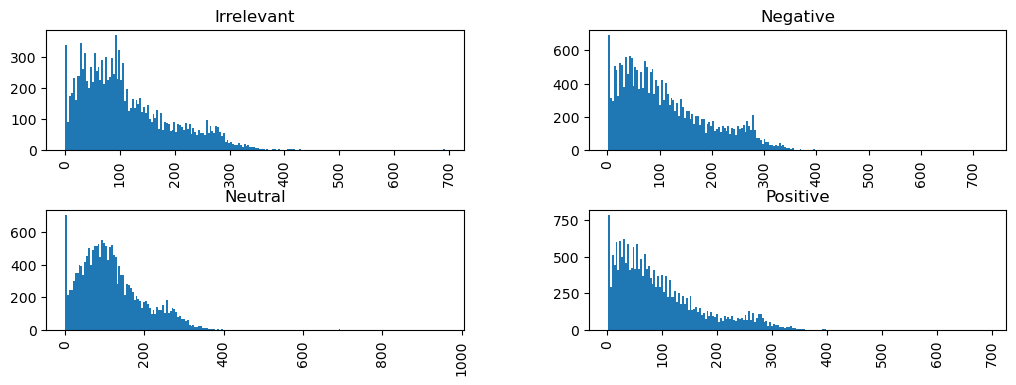

In [136]:
#Gráfico por classe
df.hist(column="Tamanho", by="Sentiment", bins=200, figsize=(12,4))

In [137]:
#Processamento de texto
def text_process(mess):
  """
  Recebe uma sequência de texto e, em seguida, executa o seguinte:
  1. Remove toda a pontução
  2. Remove todas as stopwords
  3. Retorna uma lista do texto limpo
  """
  nopunc = [char for char in mess if char not in string.punctuation]
  nopunc = ''.join(nopunc)
  return [word for word in nopunc.split() if word.lower() not in stopwords.words("english")]

In [138]:
#Teste de Tokenização dos Tweets
df['Tweet'].head(5).apply(text_process)

0       [im, getting, borderlands, murder]
1                  [coming, borders, kill]
2         [im, getting, borderlands, kill]
3        [im, coming, borderlands, murder]
4    [im, getting, borderlands, 2, murder]
Name: Tweet, dtype: object

## Vetorização

Agora, temos as mensagens como listas de tokens (também conhecidas como [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) e precisamos converter cada uma dessas mensagens em um vetor com o qual os modelos de algoritmo do SciKit Learn possam trabalhar.

Faremos isso em três etapas usando o modelo bag-of-words:

1. Contando quantas vezes uma palavra ocorre em cada mensagem (conhecida como frequência de termo)

2. Pesar as contagens, para que os tokens frequentes tenham um peso menor (frequência inversa do documento)

3. Normalizar os vetores para comprimento unitário, para abstrair do comprimento do texto original (L2 norm)

Vamos começar o primeiro passo:

Cada vetor terá tantas dimensões quantas forem as palavras únicas no corpus SMS. Primeiro, usaremos o **CountVectorizer** do SciKit Learn. Este modelo converterá uma coleção de documentos de texto em uma matriz de contagem de tokens.

Podemos imaginar isso como uma matriz bidimensional. Onde a dimensão 1 é todo o vocabulário (1 linha por palavra) e a outra dimensão são os documentos reais, neste caso uma coluna por mensagem de texto.

Por exemplo:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Como há tantas mensagens, podemos esperar muitas contagens com zero para a presença de uma dada palavra em um determinado documento. Por causa disso, o SciKit Learn produzirá uma [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

Após a contagem, a ponderação e a normalização dos termos podem ser feitas com [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), utilizando scikit-learn `TfidfTransformer`.

### O que é TF-IDF?
TF-IDF significa *term frequency-inverse document frequency*, e o tf-idf weight é um peso frequentemente usado na recuperação de informações e mineração de texto. Esse peso é uma medida estatística usada para avaliar a importância de uma palavra para um documento em uma coleção ou corpus. A importância aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento, mas é compensada pela frequência da palavra no corpus. Variações do esquema de ponderação tf-idf são frequentemente usadas pelos mecanismos de pesquisa como uma ferramenta central na pontuação e classificação da relevância de um documento dada a consulta do usuário.

Uma das funções de classificação mais simples é calculada somando o tf-idf para cada termo de consulta; muitas funções de classificação mais sofisticadas são variantes desse modelo simples.

Normalmente, o tf-idf weight é composto por dois termos: o primeiro calcula a normalized Term Frequency (TF), aka. o número de vezes que uma palavra aparece em um documento, dividido pelo número total de palavras naquele documento; o segundo termo é a Frequência Inversa de Documentos (IDF), calculada como o logaritmo do número de documentos no corpus dividido pelo número de documentos onde o termo específico aparece.

**TF: Term Frequency**, mede a frequência com que um termo ocorre em um documento. Como cada documento é diferente em tamanho, é possível que um termo apareça muito mais vezes em documentos longos do que em documentos mais curtos. Assim, a frequência do termo é frequentemente dividida pelo comprimento do documento (também conhecido como o número total de termos no documento) como forma de normalização:

*TF(t) = (Número de vezes que o termo t aparece em um documento) / (Número total de termos no documento).*

**IDF: Inverse Document Frequency**, mede a importância de um termo. Ao calcular TF, todos os termos são considerados igualmente importantes. No entanto, sabe-se que certos termos, como “é”, “de” e “isso”, podem aparecer muitas vezes, mas têm pouca importância. Assim, precisamos pesar os termos frequentes enquanto escalamos os raros, calculando o seguinte:

*IDF(t) = log(Número total de documentos / Número de documentos com termo t nele).*

Veja abaixo um exemplo simples.

**Exemplo:**

Considere um documento contendo 100 palavras em que a palavra gato aparece 3 vezes.

O termo frequência (ou seja, tf) para gato é então (3/100) = 0,03. Agora, suponha que temos 10 milhões de documentos e a palavra gato aparece em mil deles. Então, a frequência inversa do documento (ou seja, idf) é calculada como log(10.000.000 / 1.000) = 4. Assim, o peso Tf-idf é o produto dessas quantidades: 0,03 * 4 = 0,12.

## Divisão de Treino/Teste

In [139]:
msg_train, msg_test, label_train, label_test = train_test_split(df["Tweet"], df["Sentiment"], test_size=0.2)

In [140]:
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

59745 14937 74682


## Criando um pipeline de dados

Vamos executar nosso modelo novamente e, em seguida, prever fora do conjunto de teste. Usaremos o SciKit Learn [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) para armazenar um pipeline de fluxo de trabalho. Isso nos permitirá configurar todas as transformações que faremos nos dados para uso futuro. Vamos ver um exemplo de como funciona:

In [141]:
pipeline = Pipeline([
    ("bow", CountVectorizer(analyzer=text_process)),
    ("tfidf", TfidfTransformer()),
    ("classifier", MultinomialNB())                  
])

In [142]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002684817C1F0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [143]:
predictions = pipeline.predict(msg_test)

In [144]:
print(classification_report(predictions, label_test))

              precision    recall  f1-score   support

  Irrelevant       0.38      0.96      0.54      1041
    Negative       0.90      0.64      0.74      6260
     Neutral       0.61      0.81      0.69      2718
    Positive       0.80      0.69      0.74      4918

    accuracy                           0.71     14937
   macro avg       0.67      0.77      0.68     14937
weighted avg       0.78      0.71      0.72     14937

